<a href="https://colab.research.google.com/github/prakHr/Clickstream-Data-Visualization-on-raw-customer-dataset/blob/main/Copy_of_11_ImageNet_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evasion Attacks on ImageNet (Computer Vision)

We show here how to run different evasion attacks against ResNet-18, 
a DNN pretrained on ImageNet. This notebook enables running also 
CleverHans attacks (implemented in TensorFlow) against PyTorch models.

We aim to have the image of a race car misclassified as a tiger, 
using the $\ell_2$-norm targeted implementations of the Carlini-Wagner (CW) 
attack (from CleverHans), and of our PGD attack. 

We also consider a variant of our PGD attack, referred to as PGD-patch, 
where we restrict the attacker to only change the pixels of the image 
corresponding to the license plate, using a box constraint (see Melis et al., 
*Is Deep Learning Safe for Robot Vision? Adversarial Examples against the iCub Humanoid*, 
ICCVW ViPAR 2017, https://arxiv.org/abs/1708.06939).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/pralab/secml/blob/HEAD/tutorials/11-ImageNet_advanced.ipynb)

<div class="alert alert-warning">

**Warning**

Requires installation of the `pytorch` extra dependency.
See [extra components](../index.rst#extra-components) for more information.

</div>

In [ ]:
!pip install jupyter-dash

import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
# Load Data
# df = px.data.tips()
# # Build App
# app = JupyterDash(__name__)
# app.layout = html.Div([
#     html.H1("JupyterDash Demo"),
#     dcc.Graph(id='graph'),
#     html.Label([
#         "colorscale",
#         dcc.Dropdown(
#             id='colorscale-dropdown', clearable=False,
#             value='plasma', options=[
#                 {'label': c, 'value': c}
#                 for c in px.colors.named_colorscales()
#             ])
#     ]),
# ])
# # Define callback to update graph
# @app.callback(
#     Output('graph', 'figure'),
#     [Input("colorscale-dropdown", "value")]
# )
# def update_figure(colorscale):
#     return px.scatter(
#         df, x="total_bill", y="tip", color="size",
#         color_continuous_scale=colorscale,
#         render_mode="webgl", title="Tips"
#     )
# # Run app and display result inline in the notebook
# app.run_server(mode='inline')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.2 MB/s eta 0:00:00


<ipython-input-1-83ae2ca0fff2>:5: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-1-83ae2ca0fff2>:6: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [ ]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
  import torch
except ImportError:
  %pip install git+https://github.com/pralab/secml#egg=secml[pytorch]

## Load data
We start by loading the pre-trained ResNet18 model from `torchvision`, 
and we pass it to the `SecML` wrapper.  Then, we load the ImageNet labels.

In [ ]:
# NBVAL_IGNORE_OUTPUT
from torchvision import models

# Download and cache pretrained model from PyTorch model zoo
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
import io

import numpy as np
import requests
import torch

from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.features import CNormalizerMeanStd

# Set random seed for pytorch and numpy
np.random.seed(0)
torch.manual_seed(0)

# imagenet normalization
normalizer = CNormalizerMeanStd(mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225))

# wrap the model, including the normalizer
clf = CClassifierPyTorch(model=model,
                         input_shape=(3, 224, 224),
                         softmax_outputs=False,
                         preprocess=normalizer,
                         random_state=0,
                         pretrained=True)

# clf_2 = CClassifierPyTorch(model=model,
#                          input_shape=(3, 224, 224),
#                          softmax_outputs=True,
#                          preprocess=normalizer,
#                          random_state=0,
#                          pretrained=True)

# load the imagenet labels
import json

imagenet_labels_path = "https://raw.githubusercontent.com/" \
                       "anishathalye/imagenet-simple-labels/" \
                       "master/imagenet-simple-labels.json"
r = requests.get(imagenet_labels_path)
labels = json.load(io.StringIO(r.text))

2023-02-16 13:39:58,032 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data
2023-02-16 13:39:58,032 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data


INFO:secml.settings:New `SECML_HOME_DIR` created: /root/secml-data


2023-02-16 13:39:58,042 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf
2023-02-16 13:39:58,042 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf


INFO:secml.settings:Default configuration file copied to: /root/secml-data/secml.conf


2023-02-16 13:39:58,051 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets
2023-02-16 13:39:58,051 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets


INFO:secml.settings:New `SECML_DS_DIR` created: /root/secml-data/datasets


2023-02-16 13:39:58,059 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models
2023-02-16 13:39:58,059 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models


INFO:secml.settings:New `SECML_MODELS_DIR` created: /root/secml-data/models


2023-02-16 13:39:58,065 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments
2023-02-16 13:39:58,065 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments


INFO:secml.settings:New `SECML_EXP_DIR` created: /root/secml-data/experiments


2023-02-16 13:39:58,070 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs
2023-02-16 13:39:58,070 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs


INFO:secml.settings:New `SECML_LOGS_DIR` created: /root/secml-data/logs


2023-02-16 13:39:58,076 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data
2023-02-16 13:39:58,076 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


INFO:secml.settings:New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


We load the image of a race car that we would like to have misclassified 
as a tiger and we show it, along with the classifier prediction.

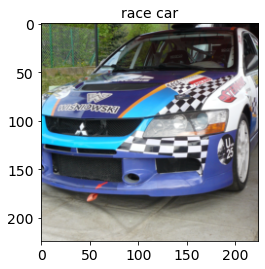

In [ ]:
import numpy as np
from PIL import Image
from torchvision import transforms

from secml.array import CArray
import cv2 as cv
import argparse
import random as rng


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),         
])

img_path = "https://images.pexels.com/photos/589782/pexels-photo-589782.jpeg"\
            "?cs=srgb&dl=car-mitshubishi-race-rally-589782.jpg&fm=jpg"
r = requests.get(img_path)
img = Image.open(io.BytesIO(r.content))

# apply transform from torchvision
img = transform(img)
# transform the image into a vector
img = torch.unsqueeze(img, 0).view(-1)
img = CArray(img.numpy())

# get the classifier prediction
preds = clf.predict(img)

pred_class = preds.item()
pred_label = labels[pred_class]

# create a function to show images
def plot_img(f, x, label):
    x = np.transpose(x.tondarray().reshape((3, 224, 224)), (1, 2, 0))
    f.sp.title(label)
    f.sp.imshow(x)
    return f 
    
# show the original image
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(height=4, width=4, fontsize=14)
plot_img(fig, img, label=pred_label)
fig.show()

## Run the attack

We should create the attack class that we will use to compute the attack.
Changing the value of the variable `attack_type`, you can choose between 
three different attacks: `CW`, `PGD`, and `PGD-patch`.

Note that the PGD-patch attack may take some time to run depending on the machine.

In [ ]:
attack_type = 'PGD-patch'
# attack_type = 'PGD'
# attack_type = 'CW'

To perform a `PGD-patch` attack that only manipulates the license plate in 
our car image, we need to define a proper box constraint along with its 
upper and lower bounds. To this end, we create the following function:

In [ ]:
def define_lb_ub(image, x_low_b, x_up_b, y_low_b, y_up_b, low_b, up_b, n_channels=3):
    
    # reshape the img (it is stored as a flat vector)
    image = image.tondarray().reshape((3, 224, 224))

    # assign to the lower and upper bound the same values of the image pixels
    low_b_patch = deepcopy(image)
    up_b_patch = deepcopy(image)

    # for each image channel, set the lower bound of the pixels in the 
    # region defined by x_low_b, x_up_b, y_low_b, y_up_b equal to lb and 
    # the upper  bound equal to up in this way the attacker will be able 
    # to modify only the pixels in this region.
    for ch in range(n_channels):
         low_b_patch[ch, x_low_b:x_up_b, y_low_b:y_up_b] = low_b
         up_b_patch[ch, x_low_b:x_up_b, y_low_b:y_up_b] = up_b

    return CArray(np.ravel(low_b_patch)), CArray(np.ravel(up_b_patch))

In [ ]:
from copy import deepcopy
def get_possible_regions(image,val=0, n_channels=3):
    src = deepcopy(np.transpose(image.tondarray().reshape((3, 224, 224)), (1, 2, 0)))
    src = src*(255)
    
    threshold = val
    # Convert image to gray and blur it
    src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    # print(np.max(src_gray))
    # print(np.min(src_gray))
    # src_gray = cv.blur(src_gray, (5,5))
    # Detect edges using Canny
    canny_output = cv.Canny(np.uint8(src_gray), 0,255)
    # print(canny_output)
    # Find contours
    contours = cv.findContours(canny_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    # print(cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE))
    # Find the convex hull object for each contour
    XYWH = []
    for i in range(len(contours)):
        hull = cv.convexHull(contours[i])
        x, y, w, h = cv.boundingRect(hull)
        XYWH.append((x,y,w,h))
    return XYWH


# def define_lb_ub_custom(image,low_b, up_b, val=0, n_channels=3):
    
#     src = deepcopy(np.transpose(image.tondarray().reshape((3, 224, 224)), (1, 2, 0)))
#     print(src.shape)
#     src = src*(255)
#     # print(src)
#     # reshape the img (it is stored as a flat vector)
#     image1 = image.tondarray().reshape((3, 224, 224))
    
#     threshold = val
#     # Convert image to gray and blur it
#     src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
#     print(np.max(src_gray))
#     print(np.min(src_gray))
#     # src_gray = cv.blur(src_gray, (5,5))
#     # Detect edges using Canny
#     canny_output = cv.Canny(np.uint8(src_gray), 0,255)
#     print(canny_output)
#     # Find contours
#     contours = cv.findContours(canny_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
#     # print(cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE))
#     # Find the convex hull object for each contour
#     hull_list = []
#     for i in range(len(contours)):
#         hull = cv.convexHull(contours[i])
#         hull_list.append(hull)
#     # print(hull_list)
#     print(len(hull_list))
#      # Draw contours + hull results
#     # drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)

#     for i in range(len(contours)):

#         color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
#         x, y, w, h = cv.boundingRect(hull_list[i])
#         # Draw a rectangle on the image using the given coordinates and color
#         # color = (0, 255, 0) # Green color
#         # thickness = 2 # Line thickness in pixels
#         # cv.rectangle(drawing, (x, y), (x+w, y+h), color, thickness)
#         # patch = img[y:y+h, x:x+w]
#         # cv.drawContours(drawing, contours, i, color)
#         # cv.drawContours(drawing, hull_list, i, color)
#     # Show in a window
#     from google.colab.patches import cv2_imshow
#     cv2_imshow(drawing)
#     # assign to the lower and upper bound the same values of the image pixels
#     low_b_patch = deepcopy(image1)
#     up_b_patch = deepcopy(image1)
#     # for ch in range(n_channels):
#     #     low_b_patch[ch, x_low_b:x_up_b, y_low_b:y_up_b] = low_b
#     #     up_b_patch[ch, x_low_b:x_up_b, y_low_b:y_up_b] = up_b

#     # for i in range(len(hull_list)):
#     #   patch_points = hull_list[i]
#     #   x = [patch_point[0][0] for patch_point in patch_points]
#     #   y = [patch_point[0][1] for patch_point in patch_points]
#     #   xy = [(x,y) for x,y in list(zip(x,y))]
#     #   # print(xy)
#     #   # print(patch_points)
#     #   # print(x)
#     #   # print(y)
#     #   x_low_b = 0
#     #   y_low_b = 0
#     #   for x,y in xy:
#     #     x_up_b = x
#     #     y_up_b = y
#     #     low_b_patch[:, x_low_b:x_up_b, y_low_b:y_up_b] = low_b
#     #     up_b_patch[:, x_low_b:x_up_b, y_low_b:y_up_b] = up_b
#     #     x_low_b = x_up_b
#     #     y_low_b = y_up_b
      
#         # low_b_patch[:, x_low_b:x_up_b, y_low_b:y_up_b] = low_b
#         # up_b_patch[:, x_low_b:x_up_b, y_low_b:y_up_b] = up_b
      
    
#     return CArray(np.ravel(low_b_patch)), CArray(np.ravel(up_b_patch))



In [ ]:
# define_lb_ub_custom(img,0, 1, val=0, n_channels=3)
XYWH = get_possible_regions(img,val=0, n_channels=3)


We instantiate and run the attack, and show the resulting adversarial 
image along with its explanations, computed via integrated gradients.

In [ ]:
from copy import deepcopy

# from cleverhans.attacks import CarliniWagnerL2

from secml.adv.attacks import CAttackEvasion
from secml.explanation import CExplainerIntegratedGradients


lb = 0 
ub = 1
target_idx = 292  # tiger 

attack_id = ''
attack_params = {}


if attack_type == 'PGD-patch':
    attack_id = 'e-pgd'
    # create the mask that we will use to allows the attack to modify only 
    # a restricted region of the image
    x_lb = 140; x_ub = 160; y_lb = 10; y_ub = 80
    dmax_patch = 5000    
    lb_patch, ub_patch = define_lb_ub(
        img, x_lb, x_ub, y_lb, y_ub, lb,ub, n_channels=3)
    solver_params = {
        'eta': 0.8,
        'max_iter': 50,
        'eps': 1e-6}

    attack_params = {'double_init': False,
                     'distance': 'l2',
                     'dmax': dmax_patch,
                     'lb': lb_patch,
                     'ub': ub_patch,
                     'y_target': target_idx,
                     'solver_params': solver_params}
    
attack = CAttackEvasion.create(
    attack_id, 
    clf, 
    **attack_params)


# run the attack
eva_y_pred, _, eva_adv_ds, _ = attack.run(img, pred_class)
adv_img = eva_adv_ds.X[0,:]


# get the classifier prediction
advx_pred = clf.predict(adv_img)
advx_label_idx = advx_pred.item()
adv_pred_label = labels[advx_label_idx]

print(f"advx_pred = {advx_pred} and adv_pred_label = {adv_pred_label} and eva_y_pred = {eva_y_pred}")
from secml.ml.classifiers.loss import CSoftmax
from secml.ml.features.normalization import CNormalizerMinMax
# classify all the points in the attack path
scores = clf.predict(attack.x_seq, return_decision_function=True)[1]

# we apply the softmax to the score to have value in [0,1]
scores = CSoftmax().softmax(scores)
print(scores.shape)
scores = scores.tondarray()
print(type(scores))
print(f"maximum index scores = {np.argmax(scores,axis = 1)} and actual scores = {np.max(scores,axis = 1)}")

# for i in range(1000):
  # print(scores[i])

# from secml.ml.peval.metrics import CMetric
# acc_torch = CMetric.create('accuracy').performance_score(advx_pred, eva_y_pred)
# print("Model Accuracy for adversarial sample: {}".format(acc_torch))


advx_pred = CArray([292]) and adv_pred_label = tiger and eva_y_pred = CArray([292])
(44, 1000)
<class 'numpy.ndarray'>
maximum index scores = [751 751 751 751 751 751 751 751 751 751 751 751 751 751 751 751 751 751
 751 751 751 751 751 751 751 290 751 751 290 751 751 751 290 751 751 751
 751 751 292 292 292 292 292 292] and actual scores = [0.76426472 0.77441858 0.73319673 0.69760867 0.69118656 0.71646975
 0.68616256 0.72906126 0.7008606  0.64573338 0.74012828 0.61705137
 0.57598595 0.54160503 0.59250348 0.51600859 0.63111576 0.53601385
 0.41650476 0.3742389  0.29827901 0.29384077 0.38173318 0.32118078
 0.26976597 0.43915581 0.38497127 0.25091653 0.17975798 0.54841957
 0.32869821 0.21497748 0.2004513  0.41856034 0.30686479 0.34168183
 0.35710404 0.29474692 0.30862573 0.39904973 0.41321168 0.35530246
 0.41592871 0.51075521]


In [ ]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

# df = pd.DataFrame()

In [ ]:
# dim_tuple_list = [(i,j) for i in range(224-1) for j in range(224-1)]


In [ ]:
# df['pixel_x'] = [i for i,j in dim_tuple_list]
# df['pixel_y'] = [j for i,j in dim_tuple_list]
# df['both_pixels'] = [f"{i},{j}" for i,j in dim_tuple_list]

In [ ]:
# df = df.iloc[1120:1122]
# df

In [ ]:
def call_attack(pixel_x,pixel_y,dx,dy,max_iter):
    attack_id = 'e-pgd'
    # create the mask that we will use to allows the attack to modify only 
    # a restricted region of the image
    x_lb = pixel_x; x_ub = pixel_x + dx; y_lb = pixel_y; y_ub = pixel_y + dy
    dmax_patch = 5000    
    lb_patch, ub_patch = define_lb_ub(img, x_lb, x_ub, y_lb, y_ub, lb,ub, n_channels=3)
    solver_params = {'eta': 0.8,'max_iter': max_iter,'eps': 1e-6}

    attack_params = {'double_init': False,
                     'distance': 'l2',
                     'dmax': dmax_patch,
                     'lb': lb_patch,
                     'ub': ub_patch,
                    #  'y_target': target_idx,
                     'solver_params': solver_params}
    
    attack = CAttackEvasion.create(attack_id, clf, **attack_params)
    eva_y_pred, _, eva_adv_ds, _ = attack.run(img, pred_class)
    # advx_pred = clf.predict(adv_img)
    # advx_label_idx = advx_pred.item()
    # adv_pred_label = labels[advx_label_idx]
    scores = clf.predict(attack.x_seq, return_decision_function=True)[1]

    # we apply the softmax to the score to have value in [0,1]
    scores = CSoftmax().softmax(scores)
    scores = scores.tondarray()
    # print(f"maximum index scores = {np.argmax(scores,axis = 1)} and actual scores = {np.max(scores,axis = 1)}")
    os = []
    score_values = []
    i=0
    average_accuracy = 0.0
    i=0
    for x,y in zip(np.argmax(scores,axis = 1),np.max(scores,axis = 1)):
      os.append(f"Actual Label = {pred_label} VS Predicted Label = {labels[int(x)]} with score = {float(y)}")
      if pred_label != labels[int(x)]:
        average_accuracy += float(y)
        i+=1
    if i!=0:
      average_accuracy /= i
      os.append(f"Average misclassification Accuracy = {average_accuracy}")
    else:
      average_accuracy = 1.0
      os.append(f"Average correct classification Accuracy = {average_accuracy}")
    # 1 chosen because label is correctly classified
    deviation = 1 - average_accuracy
    os.append(f"Deviation between Correct Accuracy and Avg Mis/correct classification Acc = {deviation}")
    if deviation > 0.5:
      os.append(f"Detected Poison Pixel")
    else:
      os.append(f"Not Detected Poison Pixel")

    return os




In [ ]:
from copy import deepcopy

# from cleverhans.attacks import CarliniWagnerL2

from secml.adv.attacks import CAttackEvasion
from secml.explanation import CExplainerIntegratedGradients
from secml.ml.classifiers.loss import CSoftmax
from secml.ml.features.normalization import CNormalizerMinMax

import pandas as pd
df = pd.DataFrame()
df['XYWH'] = XYWH
lb = 0 
ub = 1
# target_idx = 292  # tiger 
df['outputs'] = df['XYWH'].progress_apply(lambda x:call_attack(x[0],x[1],x[2],x[3],50))

  0%|          | 0/91 [00:00<?, ?it/s]

In [ ]:
df.head(5)

,XYWH,outputs
0,"(54, 177, 60, 10)",[Actual Label = race car VS Predicted Label = ...
1,"(47, 176, 6, 7)",[Actual Label = race car VS Predicted Label = ...
2,"(199, 159, 14, 18)",[Actual Label = race car VS Predicted Label = ...
3,"(109, 156, 55, 9)",[Actual Label = race car VS Predicted Label = ...
4,"(85, 154, 17, 8)",[Actual Label = race car VS Predicted Label = ...


In [ ]:
# call_attack(140,10,20,70,50)
call_attack(1,10,2,7,50)

['Actual Label = race car VS Predicted Label = race car with score = 0.7642647179031994',
 'Actual Label = race car VS Predicted Label = race car with score = 0.7569836081674702',
 'Actual Label = race car VS Predicted Label = race car with score = 0.7501244928065693',
 'Actual Label = race car VS Predicted Label = race car with score = 0.7479364595004621',
 'Actual Label = race car VS Predicted Label = race car with score = 0.7464762168585538',
 'Actual Label = race car VS Predicted Label = race car with score = 0.7451918510830167',
 'Actual Label = race car VS Predicted Label = race car with score = 0.7452706315081812',
 'Actual Label = race car VS Predicted Label = race car with score = 0.7437241275693413',
 'Actual Label = race car VS Predicted Label = race car with score = 0.744722018918887',
 'Actual Label = race car VS Predicted Label = race car with score = 0.7435673714683072',
 'Actual Label = race car VS Predicted Label = race car with score = 0.7437405454668432',
 'Actual La

In [ ]:
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Input(id='my-id', value='pixel_x_value', type="text"),
    dcc.Input(id='my-id-1', value='pixel_y_value', type="text"),
    dcc.Input(id='my-id-2', value='pixel_dx_value', type="text"),
    dcc.Input(id='my-id-3', value='pixel_dy_value', type="text"),
    dcc.Input(id='my-id-4', value='max_iter', type="text"),
    html.Button('Click Me', id='button'),
    html.Div(id='my-div')
])

@app.callback(
    Output(component_id='my-div', component_property='children'),
    [Input('button', 'n_clicks')],
    [
        State(component_id='my-id', component_property='value'),
        State(component_id='my-id-1', component_property='value'),
        State(component_id='my-id-2', component_property='value'),
        State(component_id='my-id-3', component_property='value'),
     State(component_id='my-id-4', component_property='value'),
    ]
)
def update_output_div(n_clicks, input_value,input_value_1,input_value_2,input_value_3,input_value_4):
    # return 'You\'ve entered "{}" and clicked {} times'.format(input_value, n_clicks)
    # return f"the input values are {input_value} ,{input_value_1} ,{input_value_2} ,{input_value_3}"

    px = int(input_value)
    py = int(input_value_1)
    dx = int(input_value_2)
    dy = int(input_value_3)
    max_iter = int(input_value_4)
    results = call_attack(px,py,dx,dy,max_iter)
    df_res = pd.DataFrame()
    df_res['results'] = results
    df_res['iterations #'] = [str(i) for i in range(len(results))] 
    json_dict = df_res.to_dict(orient='records')
    return str(json_dict)

app.run_server(port = 1000,debug=True,mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
# df['output'] = df.progress_apply(lambda row:call_attack(row['pixel_x'],row['pixel_y']),axis=1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# df['output'].tolist()

We compute the explanations for the adversarial image with respect to the 
target class and visualize the attack results. See the [Explainable Machine Learning](
10-Explanation.ipynb) tutorial for more information.

In [ ]:
# compute the explanations w.r.t. the target class
explainer = CExplainerIntegratedGradients(clf)
expl = explainer.explain(adv_img, y=target_idx, m=750)

fig = CFigure(height=4, width=20, fontsize=14)

fig.subplot(1, 4, 1)
# plot the original image
fig = plot_img(fig, img, label=pred_label)

# compute the adversarial perturbation 
adv_noise =  adv_img - img

# normalize perturbation for visualization
diff_img = img - adv_img
diff_img -= diff_img.min()
diff_img /= diff_img.max()

# plot the adversarial perturbation
fig.subplot(1, 4, 2)
fig = plot_img(fig, diff_img, label='adversarial perturbation')

fig.subplot(1, 4, 3) 
# plot the adversarial image
fig = plot_img(fig, adv_img, label=adv_pred_label)

fig.subplot(1, 4, 4)

expl = np.transpose(expl.tondarray().reshape((3, 224, 224)), (1, 2, 0))
r = np.fabs(expl[:, :, 0])
g = np.fabs(expl[:, :, 1])
b = np.fabs(expl[:, :, 2])

# Calculate the maximum error for each pixel
expl = np.maximum(np.maximum(r, g), b)
fig.sp.title('explanations')
fig.sp.imshow(expl, cmap='seismic')

fig.show()

KeyboardInterrupt: ignored

## Visualize and check the attack optimization

To check if the attack has properly converged to a good local minimum, 
we plot how the loss and the predicted confidence values of the target 
(solid line) and true class (dotted line) change across the attack iterations.

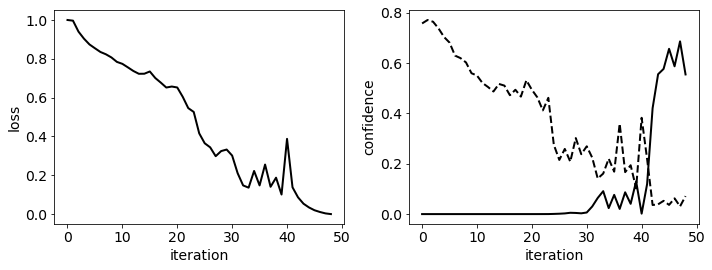

In [ ]:
from secml.ml.classifiers.loss import CSoftmax
from secml.ml.features.normalization import CNormalizerMinMax

n_iter = attack.x_seq.shape[0]
itrs = CArray.arange(n_iter)

# create a plot that shows the loss and the confidence during the attack iterations
# note that the loss is not available for all attacks
fig = CFigure(width=10, height=4, fontsize=14, linewidth=2)

# apply a linear scaling to have the loss in [0,1]
loss = attack.f_seq
if loss is not None:
    loss = CNormalizerMinMax().fit_transform(CArray(loss).T).ravel()
    fig.subplot(1, 2, 1)
    fig.sp.xlabel('iteration')
    fig.sp.ylabel('loss')
    fig.sp.plot(itrs, loss, c='black')

# classify all the points in the attack path
scores = clf.predict(attack.x_seq, return_decision_function=True)[1]

# we apply the softmax to the score to have value in [0,1]
scores = CSoftmax().softmax(scores)

fig.subplot(1, 2, 2)
fig.sp.xlabel('iteration')
fig.sp.ylabel('confidence')
fig.sp.plot(itrs, scores[:, pred_class], linestyle='--', c='black')
fig.sp.plot(itrs, scores[:, target_idx], c='black')

fig.tight_layout()
fig.show()